**Dependencies**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Pillow

In [2]:
import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sn
import torch.nn.functional as F 
from torch import nn,optim
from torchvision import transforms 
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from PIL import Image, ImageOps

# Downloading and Preparing Data

**Run this section in case you need to download the data, please mount your google drive before running this section.**

In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/HW7'

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/drive/MyDrive/HW7')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 2.29G/2.29G [00:51<00:00, 47.6MB/s]
100% 2.29G/2.29G [00:51<00:00, 48.0MB/s]


['kaggle.json', 'HW7.ipynb', 'chest-xray-pneumonia.zip']

In [ ]:
# Complete path to storage location of the .zip file of data
zip_path = '/content/drive/MyDrive/HW7/chest-xray-pneumonia.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
!unzip -q 'chest-xray-pneumonia.zip'
# View the unzipped contents in the virtual machine
os.listdir()

cp: '/content/drive/MyDrive/HW7/chest-xray-pneumonia.zip' and './chest-xray-pneumonia.zip' are the same file


['kaggle.json', 'HW7.ipynb', 'chest-xray-pneumonia.zip', 'chest_xray']

# Creating the Dataloader and the Dataset

**Specifying the paths**

In [10]:
train_normal = glob.glob('/content/drive/MyDrive/HW7/chest_xray/train/NORMAL/*')
train_pneumonia = glob.glob('/content/drive/MyDrive/HW7/chest_xray/train/PNEUMONIA/*')
test_normal = glob.glob('/content/drive/MyDrive/HW7/chest_xray/test/NORMAL/*')
test_pneumonia = glob.glob('/content/drive/MyDrive/HW7/chest_xray/test/PNEUMONIA/*')
val_normal = glob.glob('/content/drive/MyDrive/HW7/chest_xray/val/NORMAL/*')
val_pneumonia = glob.glob('/content/drive/MyDrive/HW7/chest_xray/val/PNEUMONIA/*')
train_paths = train_normal + train_pneumonia
val_paths = val_normal + val_pneumonia
test_paths = test_normal + test_pneumonia
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
val_labels = [0] * len(val_normal) + [1] * len(val_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

**Creating the dataset class**

In [11]:
class PneumoniaDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        if self.transform:
          image = self.transform(image)
    
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

**Creating Data Augmentations**

Because providing labeled medical images is a challenging task, data scientists use data augmentation techniques to increase their datasets' size and improve their models' generalizability. 

The following are some popular data augmentations in medical images:


1.   Rotation
2.   Random affine while keeping the center
3.   Cropping the image
4.   Zooming
5.   Adding noise to the image
6.   Flipping the image 
7.   (sometimes) Blurring the image

I use the first 3 of them in this code.



In [12]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((216, 216)),
    transforms.RandomApply([
         transforms.RandomApply([transforms.RandomRotation(25)], 0.7),
         transforms.RandomApply([transforms.RandomAffine(0, shear=0.2)], 0.7),
         transforms.RandomApply([transforms.RandomResizedCrop(size = 216, scale=(0.7, 1.4))], 0.7)
        ], p= 0.5)
])

test_valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((216, 216))
])

In [13]:
train_dataset = PneumoniaDataset(train_paths, train_labels, transform=train_transform)
valid_dataset = PneumoniaDataset(val_paths, val_labels, transform=test_valid_transform)
test_dataset = PneumoniaDataset(test_paths, test_labels, transform=test_valid_transform)

In [14]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Model Implementation

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,  pad, include_dropout = False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=3, padding=pad)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding= pad + 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride=3),
              nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU(inplace=True)
        self.include_dropout = include_dropout
        if self.include_dropout:
          self.dropout = nn.Dropout(0.4) 

    def forward(self, x):
        I = x.clone()
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.downsample:
            I = self.downsample(x)
        output = output + I
        if self.include_dropout:
          output = self.dropout(output)
        output = self.relu(output)
        return output

In [16]:
class PneumoniaResNet(nn.Module):
    def __init__(self, num_classes=2, include_dropout=False):
        super(PneumoniaResNet, self).__init__()
        self.in_channels = 3
        self.block1 = ResidualBlock(in_channels=3, out_channels=16, kernel_size=7, pad = 2, include_dropout=include_dropout)
        self.block2 = ResidualBlock(in_channels=16, out_channels=32, kernel_size=5, pad = 1, include_dropout=include_dropout)
        self.block3 = ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, pad = 0, include_dropout=include_dropout)
        
        self.fc = nn.Linear(4096, num_classes)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        output = self.block1(x)
        output = self.block2(output)
        output = self.block3(output)

        output = output.view(output.shape[0], -1)
        output = self.fc(output)
        output = self.softmax(output)
        return output

# Training the Network

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Without Dropout

In [11]:
model = PneumoniaResNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
tr_loss = {}
val_loss = {}
number_of_epochs = 40
for epoch in range(number_of_epochs):
    train_losses = []
    val_losses = []
    all_loss = 0
    count = 0
    for i, data in enumerate(train_dataloader):
        images = data[0]
        labels = data[1]
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels.reshape(len(labels)))
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        all_loss += loss.item()
        count += 1
    print("Epoch", epoch , ': training loss :', all_loss/count)
    

    if epoch % 5 == 0:
        for i, data in enumerate(valid_dataloader):
            images = data[0]
            labels = data[1]
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels.reshape(len(labels)))
            val_losses.append(loss.item())

        tr_loss[epoch] = np.mean(train_losses)
        val_loss[epoch] = np.mean(val_losses)
        print('Epcoh', epoch, ': average training loss =', np.mean(train_losses), ', average validation loss =', np.mean(val_losses))

torch.save(model, '/content/drive/MyDrive/HW7/model_n_drop')

Epoch 0 : training loss : 0.5575665924698114
Epcoh 0 : average training loss = 0.5575665924698114 , average validation loss = 0.603133499622345
Epoch 1 : training loss : 0.44247015193104744
Epoch 2 : training loss : 0.4054582975804806
Epoch 3 : training loss : 0.3943153526633978
Epoch 4 : training loss : 0.38946720212697983
Epoch 5 : training loss : 0.38674467615783215
Epcoh 5 : average training loss = 0.38674467615783215 , average validation loss = 0.5797154903411865
Epoch 6 : training loss : 0.3799741845577955
Epoch 7 : training loss : 0.37744346261024475
Epoch 8 : training loss : 0.3677575644105673
Epoch 9 : training loss : 0.37101467698812485
Epoch 10 : training loss : 0.372394897043705
Epcoh 10 : average training loss = 0.372394897043705 , average validation loss = 0.5852985382080078
Epoch 11 : training loss : 0.3654268216341734
Epoch 12 : training loss : 0.3624408971518278
Epoch 13 : training loss : 0.3697806876152754
Epoch 14 : training loss : 0.3637068048119545
Epoch 15 : train

**Loss Plot**

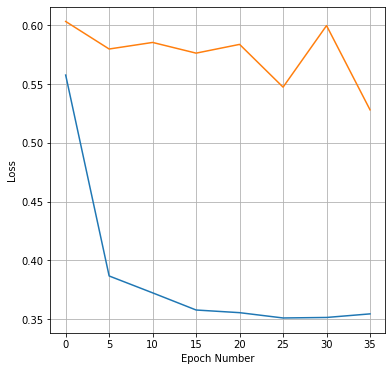

In [12]:
plt.figure(figsize=(6, 6))
plt.plot(list(tr_loss.keys()), list(tr_loss.values()))
plt.plot(list(val_loss.keys()), list(val_loss.values()))
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.show()

**Accuracy**

In [21]:
def accuracy(model, dataloader, device):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            predictions = model(data).max(1)[1] 
            labels = labels.reshape(predictions.shape)
            l = labels.cpu().detach().numpy()
            p = predictions.cpu().detach().numpy()
            tp += sum((p == 1) & (l == 1))
            tn += sum((p == 0) & (l == 0))
            fp += sum((p == 1) & (l == 0))
            fn += sum((p == 0) & (l == 1))

            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples, tp, tn, fp, fn

In [54]:
train_acc, _, _, _, _ = accuracy(model, train_dataloader, device)
valid_acc, _, _, _, _= accuracy(model, valid_dataloader, device)
test_acc, tp, tn, fp, fn = accuracy(model, test_dataloader, device)

print("\nAccuracy on training: %.2f%%" % (100*train_acc))
print("\nAccuracy on validation: %.2f%%" % (100*valid_acc))
print("\nAccuracy on test: %.2f%%" % (100*test_acc))


Accuracy on training: 96.68%

Accuracy on validation: 75.00%

Accuracy on test: 88.46%


**Confusion Matrix on test set**

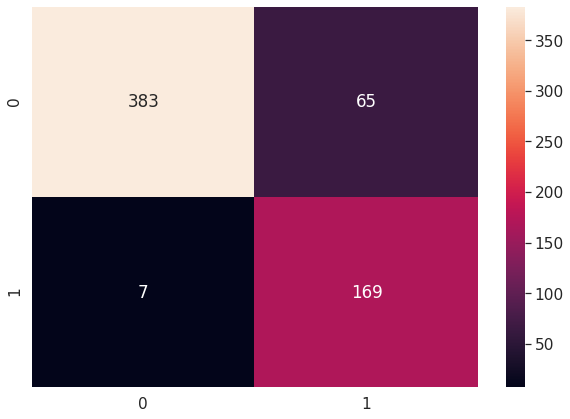

In [64]:
array = [[tp, fp], [fn, tn]]
df_cm = pd.DataFrame(array, index = range(2),
                  columns = range(2))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

## With Dropout

In [18]:
model_drop = PneumoniaResNet(include_dropout=True).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_drop.parameters(), lr=1e-4)
tr_loss = {}
val_loss = {}
number_of_epochs = 40
for epoch in range(number_of_epochs):
    train_losses = []
    val_losses = []
    all_loss = 0
    count = 0
    for i, data in enumerate(train_dataloader):
        images = data[0]
        labels = data[1]
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model_drop(images)
        loss = loss_function(outputs, labels.reshape(len(labels)))
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        all_loss += loss.item()
        count += 1
    print("Epoch", epoch , ': training loss :', all_loss/count)
    

    if epoch % 5 == 0:
        for i, data in enumerate(valid_dataloader):
            images = data[0]
            labels = data[1]
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model_drop(images)
            loss = loss_function(outputs, labels.reshape(len(labels)))
            val_losses.append(loss.item())

        tr_loss[epoch] = np.mean(train_losses)
        val_loss[epoch] = np.mean(val_losses)
        print('Epcoh', epoch, ': average training loss =', np.mean(train_losses), ', average validation loss =', np.mean(val_losses))

torch.save(model_drop, '/content/drive/MyDrive/HW7/model_drop')

Epoch 0 : training loss : 0.5875480146635146
Epcoh 0 : average training loss = 0.5875480146635146 , average validation loss = 0.8101211786270142
Epoch 1 : training loss : 0.569656423160008
Epoch 2 : training loss : 0.5683466167677016
Epoch 3 : training loss : 0.5700090612683978
Epoch 4 : training loss : 0.5694674565678551
Epoch 5 : training loss : 0.5555589170682997
Epcoh 5 : average training loss = 0.5555589170682997 , average validation loss = 0.6320110559463501
Epoch 6 : training loss : 0.4748321161383674
Epoch 7 : training loss : 0.4140504527659643
Epoch 8 : training loss : 0.39892380010514034
Epoch 9 : training loss : 0.39038480747313725
Epoch 10 : training loss : 0.3864228427410126
Epcoh 10 : average training loss = 0.3864228427410126 , average validation loss = 0.6197999715805054
Epoch 11 : training loss : 0.3818003890060243
Epoch 12 : training loss : 0.3807787157240368
Epoch 13 : training loss : 0.38135126658848356
Epoch 14 : training loss : 0.3757200567495255
Epoch 15 : traini

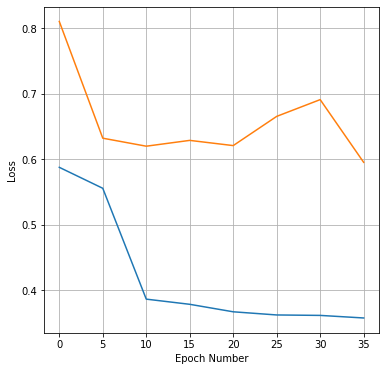

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(list(tr_loss.keys()), list(tr_loss.values()))
plt.plot(list(val_loss.keys()), list(val_loss.values()))
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [22]:
train_acc, _, _, _, _ = accuracy(model_drop, train_dataloader, device)
valid_acc, _, _, _, _= accuracy(model_drop, valid_dataloader, device)
test_acc, tp, tn, fp, fn = accuracy(model_drop, test_dataloader, device)

print("\nAccuracy on training: %.2f%%" % (100*train_acc))
print("\nAccuracy on validation: %.2f%%" % (100*valid_acc))
print("\nAccuracy on test: %.2f%%" % (100*test_acc))


Accuracy on training: 76.73%

Accuracy on validation: 50.00%

Accuracy on test: 63.14%


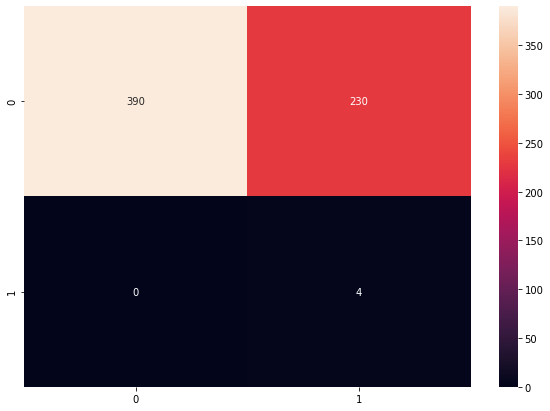

In [23]:
array = [[tp, fp], [fn, tn]]
df_cm = pd.DataFrame(array, index = range(2),
                  columns = range(2))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

**Note on Dropout:**

The dropout results are not good with the same number of epochs as the case we do not use dropout. The reason is that dropout adds some randomness to this process, meaning that it would help the model with generalization, but in this case, we need to train our model more.